# Choosing between earlier and later expressions, given two groups' observed interactions

December 2024

In [1]:
import numpy as np
import pandas as pd

from memo import memo
import jax
import jax.numpy as jnp
from jax import lax
from enum import IntEnum

## 1. Generate model predictions with binary utilities based on design

What are the utilities involved? 

- Referential informativity
    - 1 for all earlier utterances regardless of group; 1 for later utterances to in-group; 0 for later utterances to out-group if 'group-specific label' tangram, 1 if 'shared label' tangram
    - so that means, for later utterances, 0.5 to 'either' group for the 'group-specific' labels but 1 to 'either' group for the 'shared' labels
- Social informativity: 0 for all earlier utterances, 1 for all later utterances
- Utterance cost: 1 for all earlier utterances, 0 for all later utterances

In [2]:
# type: ignore
class AudienceConditions(IntEnum):
    EitherGroup = 0
    OneGroup = 1


class Audiences(IntEnum):
    Ingroup = 1
    Outgroup = 0


class TangramTypes(IntEnum):
    Shared = 0
    GroupSpecific = 1


class Utterances(IntEnum):
    Earlier = 0
    Later = 1


@jax.jit
def audience_wpp(audience_condition, audience):
    # for the "either group" condition, return 1 regardless of audience
    # for the "one group" condition, return 1 for the ingroup and 0 for the outgroup
    return jnp.array([1, audience])[audience_condition]


@jax.jit
def ref_info(audience, tangram_type, utterance):
    ingroup_info = jnp.array([1, 1])  # [earlier, later]
    outgroup_info = lax.cond(
        tangram_type == TangramTypes.Shared,
        lambda _: jnp.array(
            [1, 1]
        ),  # if it's a shared-label tangram, the later utterance is informative regardless of group
        lambda _: jnp.array([1, 0]),
        operand=None,
    )

    info = lax.cond(
        audience == Audiences.Ingroup,
        lambda _: ingroup_info,
        lambda _: outgroup_info,
        operand=None,
    )

    return info[utterance]


@jax.jit
def social_info(utterance):
    return jnp.array([0, 1])[utterance]


@jax.jit
def cost(utterance):
    return jnp.array([1, 0])[utterance]


@memo
def speaker[
    utterance: Utterances, audience: Audiences
](
    audience_condition: AudienceConditions,
    tangram_type: TangramTypes,
    alpha,
    w_r,
    w_s,
    w_c,
):
    cast: [speaker]
    speaker: chooses(
        audience in Audiences, wpp=audience_wpp(audience_condition, audience)
    )
    speaker: chooses(
        utterance in Utterances,
        wpp=exp(
            alpha
            * (
                w_r * ref_info(audience, tangram_type, utterance)
                + w_s * social_info(utterance)
                - w_c * cost(utterance)
            )
        ),
    )
    return Pr[speaker.utterance == utterance]

## Generate model predictions and fit weights

In [3]:
class Conditions(IntEnum):
    ReferEither = 0
    ReferOne = 1
    SocialOne = 2

Generate model predictions for all conditions (FYI for best fit we might need a `w_s` (i.e. don't fix it to 0) for the 'refer one' condition)

In [4]:
@jax.jit
def get_model_preds(alpha, w_r, w_s, w_c):
    """
    Get the model predictions for all conditions and tangram types
    Output: 3x2 (condition, tangram type) array of probability of choosing the later utterance
    """
    conditions_vals = jnp.array(
        [Conditions.ReferEither, Conditions.ReferOne, Conditions.SocialOne]
    )
    tangrams_vals = jnp.array([TangramTypes.Shared, TangramTypes.GroupSpecific])

    def single_pred(cond, ttype):
        return lax.cond(
            cond == Conditions.ReferEither,
            lambda _: speaker(
                AudienceConditions.EitherGroup, ttype, alpha, w_r, 0, w_c
            ),
            lambda _: lax.cond(
                cond == Conditions.ReferOne,
                lambda __: speaker(
                    AudienceConditions.OneGroup, ttype, alpha, w_r, 0, w_c
                ),
                lambda __: speaker(
                    AudienceConditions.OneGroup, ttype, alpha, w_r, w_s, w_c
                ),
                operand=None,
            ),
            operand=None,
        )[Utterances.Later, 0]

    # Vectorize over tangrams first, then over conditions
    vmap_tangrams = jax.vmap(
        lambda c: jax.vmap(lambda t: single_pred(c, t))(tangrams_vals)
    )
    return vmap_tangrams(conditions_vals)

In [5]:
get_model_preds(1, 1, 1, 0.1)

Array([[0.5249792 , 0.40701485],
       [0.5249792 , 0.5249792 ],
       [0.7502601 , 0.7502601 ]], dtype=float32)

## Load data and get it into a matrix format

Data array, for each participant: tangram (A through L) x audience group (red vs. blue) x condition ('refer either' vs. 'refer one' vs. 'social one'). 

For each participant, only half of the tangrams have values because each participant only sees 6 tangrams. There are 6 * 2 * 3 = 36 critical trials per participant. 

In [6]:
class Tangram(IntEnum):
    A = 0
    B = 1
    C = 2
    D = 3
    E = 4
    F = 5
    G = 6
    H = 7
    I = 8
    J = 9
    K = 10
    L = 11

class AudienceGroup(IntEnum):
    Red = 0
    Blue = 1

class Counterbalance(IntEnum):
    a = 0
    b = 1

In [7]:
data = pd.read_csv("../data/3pp/earlier-later/selection_trials_clean.csv").rename(
    columns={"item_id": "tangram_set", 
             "shared": "tangram_type"}
)
data.loc[data["condition"] == "either refer", "condition"] = "ReferEither"
data.loc[data["condition"] == "one refer", "condition"] = "ReferOne"
data.loc[data["condition"] == "one social", "condition"] = "SocialOne"

data.loc[data["response.earlier"] == "earlier", "response.earlier"] = 1
data.loc[data["response.earlier"] == "later", "response.earlier"] = 0

data["response.later"] = 1 - data["response.earlier"]

data.loc[data["tangram_type"] == "shared", "tangram_type"] = "Shared"
data.loc[data["tangram_type"] == "unique", "tangram_type"] = "GroupSpecific"

data.loc[data["audience_group"] == "red", "audience_group"] = "Red"
data.loc[data["audience_group"] == "blue", "audience_group"] = "Blue"

data.head()

,subject_id,tangram_set,counterbalance,condition,audience_group,tangram,tangram_type,response.earlier,response.later
0,dd2c8d9a-acab-46b0-a2d6-58e7c914ac4e,0,a,SocialOne,Red,C,Shared,0,1
1,dd2c8d9a-acab-46b0-a2d6-58e7c914ac4e,0,a,ReferEither,Blue,B,Shared,0,1
2,dd2c8d9a-acab-46b0-a2d6-58e7c914ac4e,0,a,SocialOne,Blue,L,Shared,0,1
3,dd2c8d9a-acab-46b0-a2d6-58e7c914ac4e,0,a,ReferOne,Blue,L,Shared,0,1
4,dd2c8d9a-acab-46b0-a2d6-58e7c914ac4e,0,a,ReferOne,Red,H,GroupSpecific,1,0


Save what tangrams are shared and what tangrams are group-specific

tangram set x counterbalance x tangram 

In [8]:
is_group_specific = np.zeros((3, 2, 12)) # tangram_set, counterbalance, tangram
# group by tangram_set, counterbalance, tangram
tangram_info = data.groupby(["tangram_set", "counterbalance", "tangram_type", "tangram"]).size()
tangram_info = tangram_info.reset_index(name="count")

for _, row in tangram_info.iterrows():
    tangram_set = row["tangram_set"]
    counterbalance = row["counterbalance"]
    tangram = row["tangram"]
    tangram_type = row["tangram_type"]
    is_group_specific[tangram_set, Counterbalance[counterbalance], Tangram[tangram]] = tangram_type == "GroupSpecific"

In [9]:
tangram_info

,tangram_set,counterbalance,tangram_type,tangram,count
0,0,a,GroupSpecific,A,48
1,0,a,GroupSpecific,D,48
2,0,a,GroupSpecific,H,48
3,0,a,Shared,B,48
4,0,a,Shared,C,48
5,0,a,Shared,L,48
6,0,b,GroupSpecific,B,54
7,0,b,GroupSpecific,C,54
8,0,b,GroupSpecific,L,54
9,0,b,Shared,A,54


In [10]:
data_organized = {}
for tangram_set in [0, 1, 2]:
    for counterbalance in ["a", "b"]:
        filtered_data = data[
            (data["tangram_set"] == tangram_set)
            & (data["counterbalance"] == counterbalance)
        ]
        filtered_data_participants = filtered_data["subject_id"].unique()

        this_set_mtx = np.zeros(
            (12, 2, len(Conditions), len(filtered_data_participants))
        )
        for i, participant in enumerate(filtered_data_participants):
            this_data = filtered_data[filtered_data["subject_id"] == participant]
            this_participant_mtx = np.zeros((12, 2, len(Conditions)))
            for _, row in this_data.iterrows():
                this_participant_mtx[
                    Tangram[row["tangram"]],
                    AudienceGroup[row["audience_group"]],
                    Conditions[row["condition"]],
                ] = row["response.later"]
                this_set_mtx[:, :, :, i] = this_participant_mtx

        data_organized[(tangram_set, counterbalance)] = this_set_mtx

In [11]:
for key, mtx in data_organized.items():
    print(key, mtx.shape)
# tangram x audience x condition x participant

(0, 'a') (12, 2, 3, 8)
(0, 'b') (12, 2, 3, 9)
(1, 'a') (12, 2, 3, 11)
(1, 'b') (12, 2, 3, 13)
(2, 'a') (12, 2, 3, 11)
(2, 'b') (12, 2, 3, 9)


Iterate through sets and counterbalance, and create model predictions for each

In [12]:
@jax.jit
def format_model_preds(model_preds, data_organized):
    """format model predictions to match the data_organized format
    needs tangram_info, which is information about what tangrams belong to which set and counterbalance etc. (rename later)
    this can probably be sped up
    """
    all_preds = {}
    for key, mtx in data_organized.items():
        tangram_set, counterbalance = key
        preds = jnp.zeros((12, 2, len(Conditions)))
        available = tangram_info[(tangram_info["tangram_set"] == tangram_set) & (tangram_info["counterbalance"] == counterbalance)]
        for _, row in available.iterrows():
            for condition in Conditions: 
                preds = preds.at[Tangram[row["tangram"]], :, condition].set(model_preds[condition, TangramTypes[row["tangram_type"]]])

        # repeat by number of participants
        all_preds[key] = jnp.repeat(preds[:, :, :, jnp.newaxis], mtx.shape[-1], axis=-1)
    return all_preds


In [13]:
model_organized = format_model_preds(get_model_preds(1, 1, 1, 0.1), data_organized)

Stack all the matrices

In [14]:
data_matrices = []
model_matrices = []

# get rid of entirely empty slices (tangrams that were not used) along 0th dim
for mtx in model_organized.values():
    mask = ~jnp.all(mtx == 0, axis=(1, 2, 3))
    model_matrices.append(mtx[mask])

for mtx in data_organized.values():
    mask = ~jnp.all(mtx == 0, axis=(1, 2, 3))
    data_matrices.append(mtx[mask])

data_all = jnp.concatenate(data_matrices, axis=-1)
model_all = jnp.concatenate(model_matrices, axis=-1)
assert data_all.shape == model_all.shape

Compute NLL and optimize

In [15]:
@jax.jit
def compute_nll(data, model):
    nll = -jnp.sum(
        data * jnp.log(model + 1e-7) + (1 - data) * jnp.log(1 - model + 1e-7)
    )
    return nll

In [16]:
compute_nll(data_all, model_all)

Array(1450.3622, dtype=float32)

### Optimization

In [17]:
# Make grid of parameter values
alphas = jnp.arange(0, 5, 0.1)
w_rs = jnp.arange(0, 5, 0.1)
w_ss = jnp.arange(0, 5, 0.1)
w_cs = jnp.arange(0, 5, 0.1)

# make grid of all values
param_grid = jnp.meshgrid(alphas, w_rs, w_ss, w_cs)

# Flatten the parameter grid
all_alphas = param_grid[0].ravel()
all_wrs    = param_grid[1].ravel()
all_wss    = param_grid[2].ravel()
all_wcs    = param_grid[3].ravel()

params_list = jnp.stack([all_alphas, all_wrs, all_wss, all_wcs], axis=1)

In [18]:
def grid_search_nll():

    # Offline: build a single "list of slices" or "list of offsets" across the dictionary.
    reference_mo = format_model_preds(get_model_preds(1, 1, 1, 0.1), data_organized)  # arbitrary params
    # TODO: store the above elsewhere
    
    model_slices = []
    for key, original_mtx in reference_mo.items():
        mask = ~jnp.all(original_mtx == 0, axis=(1,2,3))  # shape (12,)
        assert jnp.array_equal(mask, ~jnp.all(data_organized[key] == 0, axis=(1,2,3)))
        # which indices survived?
        surviving_indices = jnp.where(mask)[0]           # shape (k,)
        model_slices.append((key, surviving_indices))

    def single_nll(params):
        alpha, w_r, w_s, w_c = params
        preds = get_model_preds(alpha, w_r, w_s, w_c)
        mo    = format_model_preds(preds, data_organized)
            # Rebuild the final mo_all by slicing just once

        masked_arrays = []
        for (key, surviving_indices) in model_slices:
            mtx = mo[key]
            masked_arrays.append(mtx[surviving_indices])  # (k, 2, 3, Nx)

        mo_all = jnp.concatenate(masked_arrays, axis=-1) 
        return compute_nll(data_all, mo_all)
    
    nll_values  = jax.vmap(single_nll)(params_list)

    # Find best NLL
    best_idx   = jnp.argmin(nll_values)
    assert best_idx < len(nll_values)
    best_nll   = nll_values[best_idx]
    best_params = params_list[best_idx]
    return best_params, best_nll, nll_values

best_params, best_nll_val, nll_values = grid_search_nll()
print("Best NLL:", best_nll_val)
print("Best params (alpha, w_r, w_s, w_c):", best_params)

Best NLL: 1410.3212
Best params (alpha, w_r, w_s, w_c): [0.5 3.4 0.5 1.2]


In [19]:
# No social goals possible at all (w_s fixed to 0 for all conditions)
# Best NLL: 1413.0602
# Best params (alpha, w_r, w_s, w_c): [1.  1.9 0.  0.7]

# Yes social goal on only social trial (w_s fixed to zero on refer trials)
# Best NLL: 1410.3212
# Best params (alpha, w_r, w_s, w_c): [0.5 3.4 0.5 1.2]

# Social goal on 'one group' audience (w_s fixed to zero on 'either group' audience)
# Best NLL: 1409.7126
# Best params (alpha, w_r, w_s, w_c): [0.3 4.6 1.1 1.5]

In [20]:
preds_no_social = get_model_preds(1, 1.9, 0, 0.7)
preds_social = get_model_preds(0.5, 3.4, 0.5, 1.2)

print(preds_no_social)
print(preds_social)


[[0.66818774 0.4498315 ]
 [0.66818774 0.66818774]
 [0.66818774 0.66818774]]
[[0.64565635 0.44769812]
 [0.64565635 0.64565635]
 [0.7005671  0.7005671 ]]


Seems like fits aren't great. Let's also vary $w_s$ for the 'refer one' condition

In [21]:
@jax.jit
def get_model_preds_onegroup_social(alpha, w_r, w_s, w_c):
    """
    Now there is social weight on both of the 'one group' audience conditions
    Get the model predictions for all conditions and tangram types
    Output: 3x2 (condition, tangram type) array of probability of choosing the later utterance
    """
    conditions_vals = jnp.array(
        [Conditions.ReferEither, Conditions.ReferOne, Conditions.SocialOne]
    )
    tangrams_vals = jnp.array([TangramTypes.Shared, TangramTypes.GroupSpecific])

    def single_pred(cond, ttype):
        return lax.cond(
            cond == Conditions.ReferEither,
            lambda _: speaker(
                AudienceConditions.EitherGroup, ttype, alpha, w_r, 0, w_c
            ),
            lambda _: lax.cond(
                cond == Conditions.ReferOne,
                lambda __: speaker(
                    AudienceConditions.OneGroup, ttype, alpha, w_r, w_s, w_c
                ),
                lambda __: speaker(
                    AudienceConditions.OneGroup, ttype, alpha, w_r, w_s, w_c
                ),
                operand=None,
            ),
            operand=None,
        )[Utterances.Later, 0]

    # Vectorize over tangrams first, then over conditions
    vmap_tangrams = jax.vmap(
        lambda c: jax.vmap(lambda t: single_pred(c, t))(tangrams_vals)
    )
    return vmap_tangrams(conditions_vals)

best_params_social, best_nll_val_social, nll_values_social = grid_search_nll()
preds_social_both = get_model_preds_onegroup_social(*best_params_social)
preds_social_both

Array([[0.64565635, 0.44769812],
       [0.7005671 , 0.7005671 ],
       [0.7005671 , 0.7005671 ]], dtype=float32)

Combine all the results

In [22]:
# Put it in a dataframe
df_preds = pd.DataFrame(columns=["type", "condition", "tangram_type", "p_earlier"])
rows = []
for condition in Conditions:
    for tangram_type in TangramTypes:
        rows.append(
            {
                "type": "no_social",
                "condition": condition.name,
                "tangram_type": tangram_type.name,
                "p_earlier": 1 - preds_no_social[condition, tangram_type],
            }
        )

for condition in Conditions:
    for tangram_type in TangramTypes:
        rows.append(
            {
                "type": "social",
                "condition": condition.name,
                "tangram_type": tangram_type.name,
                "p_earlier": 1 - preds_social[condition, tangram_type],
            }
        )

for condition in Conditions:
    for tangram_type in TangramTypes:
        rows.append(
            {
                "type": "social_both",
                "condition": condition.name,
                "tangram_type": tangram_type.name,
                "p_earlier": 1 - preds_social_both[condition, tangram_type],
            }
        )
df_preds = pd.concat([df_preds, pd.DataFrame(rows)], ignore_index=True)

# remove jax stuff
df_preds["p_earlier"] = df_preds["p_earlier"].apply(lambda x: x.item())

In [23]:
df_preds

,type,condition,tangram_type,p_earlier
0,no_social,ReferEither,Shared,0.331812
1,no_social,ReferEither,GroupSpecific,0.550169
2,no_social,ReferOne,Shared,0.331812
3,no_social,ReferOne,GroupSpecific,0.331812
4,no_social,SocialOne,Shared,0.331812
5,no_social,SocialOne,GroupSpecific,0.331812
6,social,ReferEither,Shared,0.354344
7,social,ReferEither,GroupSpecific,0.552302
8,social,ReferOne,Shared,0.354344
9,social,ReferOne,GroupSpecific,0.354344


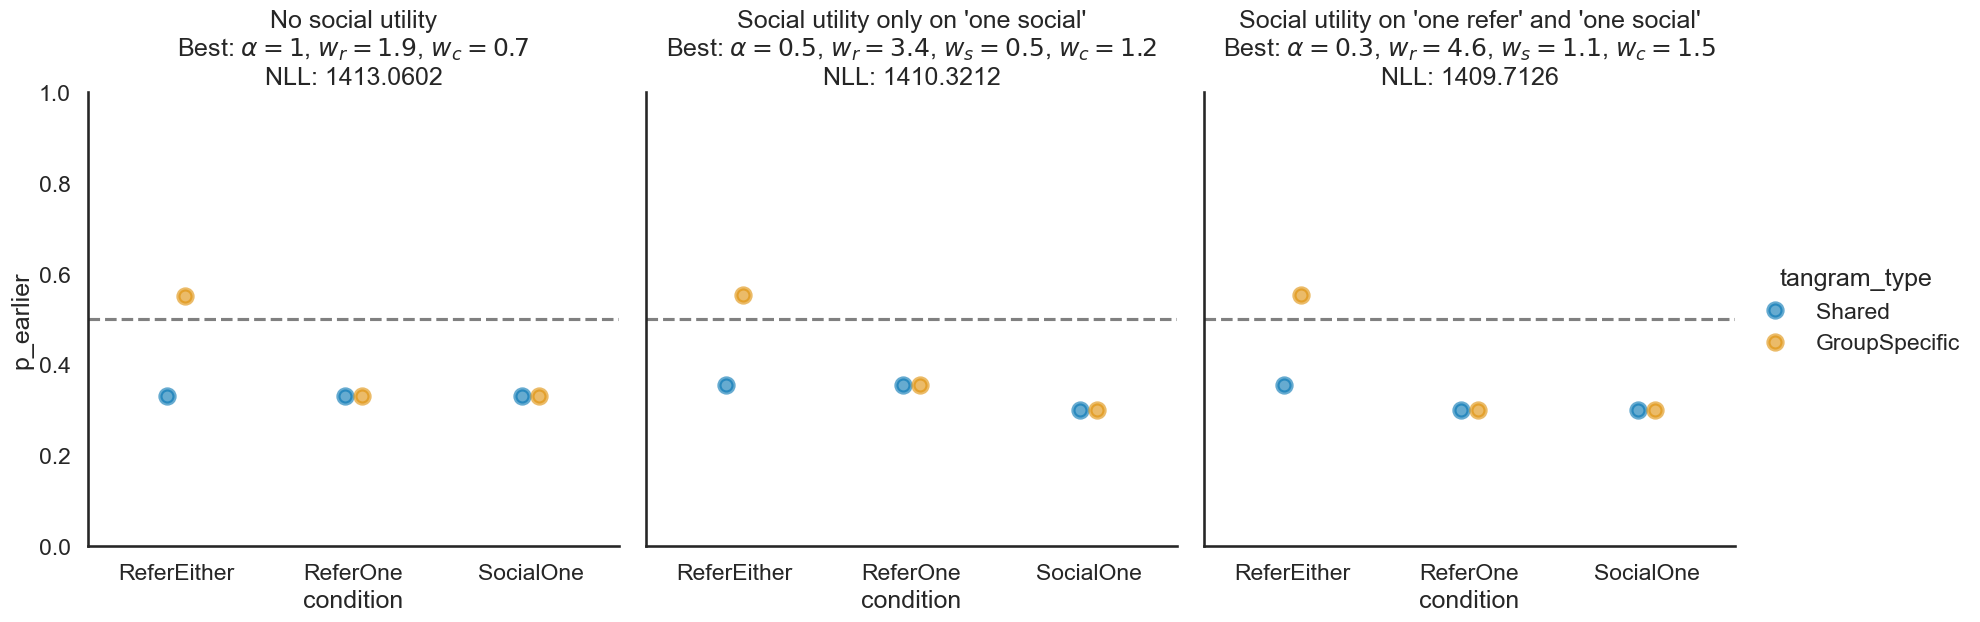

In [24]:
# plot
import seaborn as sns
import matplotlib.pyplot as plt

sns.set_context("talk")
sns.set_style("white")

g = sns.catplot(
    data=df_preds,
    x="condition",
    y="p_earlier",
    hue="tangram_type",
    col="type",
    kind="point",
    height=6,
    aspect=1,
    palette="colorblind",
    dodge=0.1,
    alpha=0.6,
    linestyle="none",
)

g.set(ylim=(0, 1))
for ax in g.axes.flat:
    ax.axhline(0.5, ls="--", color="gray")

# add an extra title to each of the plots
titles = [
    "No social utility\nBest: $\\alpha=1$, $w_r=1.9$, $w_c=0.7$\nNLL: 1413.0602",
    "Social utility only on 'one social'\nBest: $\\alpha=0.5$, $w_r=3.4$, $w_s=0.5$, $w_c=1.2$\nNLL: 1410.3212",
    "Social utility on 'one refer' and 'one social'\nBest: $\\alpha=0.3$, $w_r=4.6$, $w_s=1.1$, $w_c=1.5$\nNLL: 1409.7126",
]
for ax, title in zip(g.axes.flat, titles):
    ax.set_title(title)  # add padding to the title
plt.show()

In [25]:
# do likelihood ratio test between the "no social" and "social" models
from scipy.stats import chi2


In [26]:
from scipy.stats import chi2

# Compute the likelihood ratio test statistic
lr_stat = 2 * (best_nll_val - best_nll_val_social)

# Degrees of freedom: number of additional parameters in the "social" model
df = 1  # w_s is the additional parameter

# Compute the p-value
p_value = chi2.sf(lr_stat, df)

print(f"Likelihood Ratio Test Statistic: {lr_stat}")
print(f"Degrees of Freedom: {df}")
print(f"P-value: {p_value}")

Likelihood Ratio Test Statistic: 0.0
Degrees of Freedom: 1
P-value: 1.0
